In [1]:
import tensorflow as tf
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.experimental import LinearModel

In [2]:
%config Completer.use_jedi = False

In [3]:
# Uncomment the following to disable GPU
tf.config.set_visible_devices([], 'GPU')
print(tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
1 Physical GPUs, 0 Logical GPUs


# Import parquet data

In [4]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
ptable = ds.read().to_pandas()

In [5]:
# Get rid of outliers in power feture
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)
power = ptable['power'].apply(lambda a: clamp(a[0], 0.0, 99.0))

In [6]:
def feature_names():
    l = list(ptable.columns.values)
    l.remove('label')
    return l

def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)

def dim(val):
    return 1 if isinstance(val, float) or isinstance(val, int) else len(val)

def generator_shapes():
    _, row = next(ptable.iterrows())
    shapes = {k: (1, dim(row[k])) for k in feature_names()}
    return tuple([shapes, (1,)])

print(feature_names())
print(generator_types())
print(generator_shapes())

['timestamp', 'cpuinfo', 'profile', 'cpu_idle', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'power', 'temp', 'fan_rpm', 'year', 'month', 'day']
({'timestamp': tf.float32, 'cpuinfo': tf.float32, 'profile': tf.float32, 'cpu_idle': tf.float32, 'cpu_user': tf.float32, 'cpu_system': tf.float32, 'cpu_nice': tf.float32, 'power_constraints': tf.float32, 'power': tf.float32, 'temp': tf.float32, 'fan_rpm': tf.float32, 'year': tf.float32, 'month': tf.float32, 'day': tf.float32}, tf.float32)
({'timestamp': (1, 1), 'cpuinfo': (1, 8), 'profile': (1, 1), 'cpu_idle': (1, 8), 'cpu_user': (1, 8), 'cpu_system': (1, 8), 'cpu_nice': (1, 8), 'power_constraints': (1, 2), 'power': (1, 1), 'temp': (1, 10), 'fan_rpm': (1, 1), 'year': (1, 1), 'month': (1, 1), 'day': (1, 1)}, (1,))


In [7]:
def convert(key, value):
    if isinstance(value, float) or isinstance(value, int):
        return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, 1))
    return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, dim(value)))

def generator():
    for index, row in ptable.iterrows():
        f = {k: convert(k, row[k]) for k in feature_names()}
        l = tf.convert_to_tensor(list([float(row['label'])]), tf.float32, name='label')
        yield f, l

In [8]:
all = tf.data.Dataset.from_generator(generator, output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)
n = next(all.batch(2).as_numpy_iterator())
print(n)

({'timestamp': array([[[1.6376166e+09]],

       [[1.6376166e+09]]], dtype=float32), 'cpuinfo': array([[[2800.   , 2800.   , 2800.   , 2800.   , 2800.   , 2800.   ,
         2800.   , 2022.431]],

       [[2800.   , 2800.   , 2800.   , 1898.875, 2800.   , 2800.   ,
         2800.   , 2800.   ]]], dtype=float32), 'profile': array([[[1.]],

       [[1.]]], dtype=float32), 'cpu_idle': array([[[0.92      , 0.9607843 , 1.        , 0.9423077 , 0.9375    ,
         1.        , 0.98039216, 0.8627451 ]],

       [[0.9861111 , 0.9577465 , 0.9027778 , 0.9104478 , 0.9701493 ,
         1.        , 0.942029  , 0.9859155 ]]], dtype=float32), 'cpu_user': array([[[0.02      , 0.03921569, 0.        , 0.03846154, 0.02083333,
         0.        , 0.01960784, 0.05882353]],

       [[0.01388889, 0.02816901, 0.05555556, 0.01492537, 0.        ,
         0.        , 0.01449275, 0.01408451]]], dtype=float32), 'cpu_system': array([[[0.06      , 0.        , 0.        , 0.01923077, 0.04166667,
         0.        ,

In [9]:
tf.shape(n[0]['temp']).numpy()

array([ 2,  1, 10], dtype=int32)

In [10]:
tf.shape(n[1]).numpy()

array([2, 1], dtype=int32)

In [11]:
def is_test(x, y):
    return x % 4 == 0
def is_train(x, y):
    return not is_test(x, y)
recover = lambda x,y: y
test_dataset = all.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = all.enumerate() \
                    .filter(is_train) \
                    .map(recover)

# Lets build a simple model

In [12]:
from tensorflow.keras import layers
from tensorflow import keras

In [13]:
temp_input = Input(shape=(10,), name="temp")
cpu_idle_input = Input(shape=(8,), name="cpu_idle")
power_input = Input(shape=(1,), name="power")
fan_input = Input(shape=(1,), name="fan_rpm")
all_input = [power_input, temp_input, cpu_idle_input, fan_input]

In [14]:
x = layers.concatenate(all_input)

In [15]:
fanlevel_output = Dense(1, name="level")(x)

In [16]:
linear_model=keras.Model(inputs=all_input, outputs=[fanlevel_output])
linear_model.compile(optimizer='adam', loss='msle')

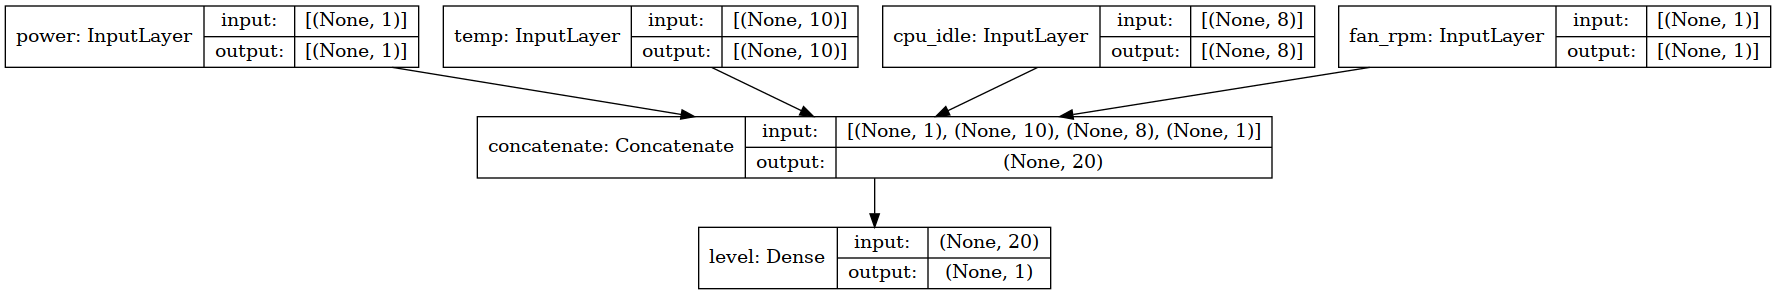

In [17]:
keras.utils.plot_model(linear_model, "multi_input_and_output_model.png", show_shapes=True)

In [18]:
linear_model.fit(train_dataset, epochs=1, batch_size=1024)

/home/danielk/.pyenv/versions/3.6.11/envs/smart-fancontrol/lib/python3.6/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['timestamp', 'cpuinfo', 'profile', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'year', 'month', 'day'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


2047125/2047125 [==============================] - 7059s 3ms/step - loss: nan


In [19]:
linear_model.save("first_train")

INFO:tensorflow:Assets written to: first_train/assets


This model diverged after two hours of training. In the next notebook, [Clean-data](Clean-data.ipynb) we resample the data for both faster trainng and better results. We could also reweigh the data but we'd still train too slowly.